In [57]:
import os
import cv2
import dlib
import openface
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

os.environ['KERAS_BACKEND']='theano' 

from skimage import io
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import optimizers

%matplotlib inline

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


### Face Landmarks

In [2]:
# Docs:
# - http://openface-api.readthedocs.io/en/latest/index.html
# - http://dlib.net/python/index.html

# Pre-trained face detection model
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model = 'Resources/shape_predictor_68_face_landmarks.dat'

# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)
face_aligner = openface.AlignDlib(predictor_model)

### Loading and Pre-Processing Data

In [3]:
labels = []
images = []

path = 'Data/yalefaces'
for p in os.listdir(path):
    images.append(io.imread(os.path.join(path, p), as_grey=True))
    labels.append(int(p.split('.')[0].replace('subject', '')))

In [4]:
print 'Number of unique labels:', len(set(labels))
print 'Number of images:', len(labels)

Number of unique labels: 15
Number of images: 166


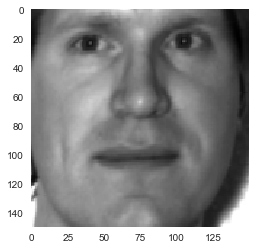

In [5]:
def get_face(image):
    # Run the HOG face detector on the image data
    detected_faces = face_detector(image, 1)
    # win = dlib.image_window()
    # win.set_image(image)
    # print("Found {} face(s) in the image file {}".format(len(detected_faces), labels[0]))
    # Loop through each face we found in the image
    for i, face_rect in enumerate(detected_faces):
        # Detected faces are returned as an object with the coordinates 
        # of the top, left, right and bottom edges
        # print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom())) 
        # Get the the face's pose
        pose_landmarks = face_pose_predictor(image, face_rect)
        # win.add_overlay(pose_landmarks)
        # Use openface to calculate and perform the face alignment
        alignedFace = face_aligner.align(150, image, face_rect, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
        return alignedFace

In [14]:
bad = []
for i, image in enumerate(images):
    face = get_face(image)
    if face is None:
        bad.append(i)
    else:
        images[i] = face

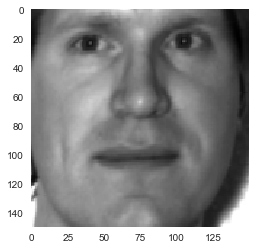

In [15]:
plt.figure()
plt.grid(False)
plt.imshow(images[0], cmap='gray')

In [34]:
print images[0].shape 
print np.array(images).shape

(150, 150)
(161,)


[50, 115]
Remanescent images: 161


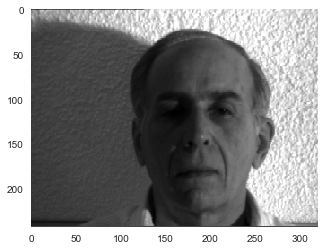

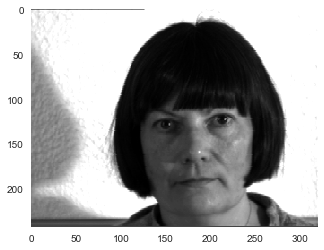

In [24]:
for i in bad:
    plt.figure()
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
    
for i in bad:
    del images[i]
    del labels[i]
 
print bad
print 'Remanescent images:', len(images)

In [25]:
X = np.array(images)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [42]:
X_train /= 255.
X_test /= 255.

In [45]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

NameError: name 'to_categorical' is not defined

### Model

In [ ]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

In [ ]:
# https://martinbel.github.io/face-detection.html
# https://github.com/rajathkumarmp/FaceRecog-Keras/blob/master/faceRecog.ipynb